<a href="https://colab.research.google.com/github/SomSubhroN/Micro_Counterfactual_paradox/blob/main/micro_counterfactual_paradox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA available: True
Paraphraser loaded: google/flan-t5-base

Generating paraphrase pairs...



100%|██████████| 200/200 [00:36<00:00,  5.50it/s]


Saved paradox_pairs.csv with 200 pairs.


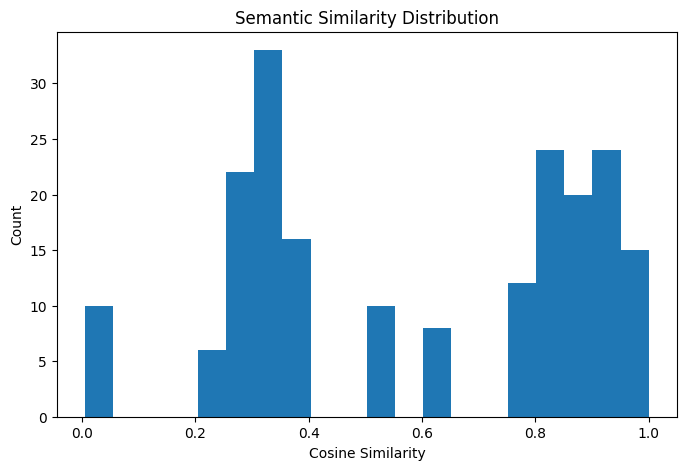

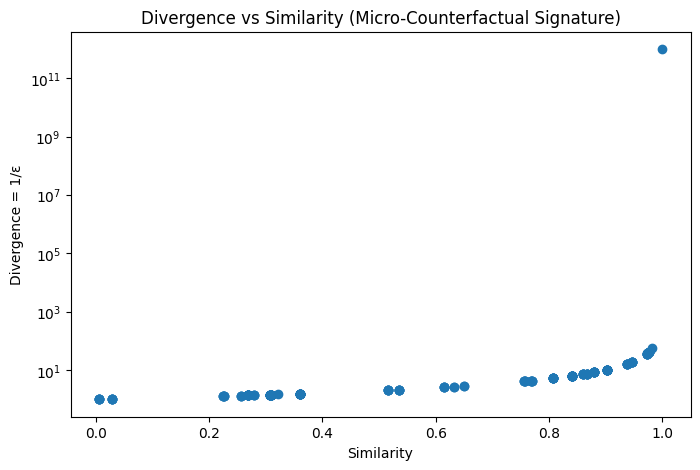

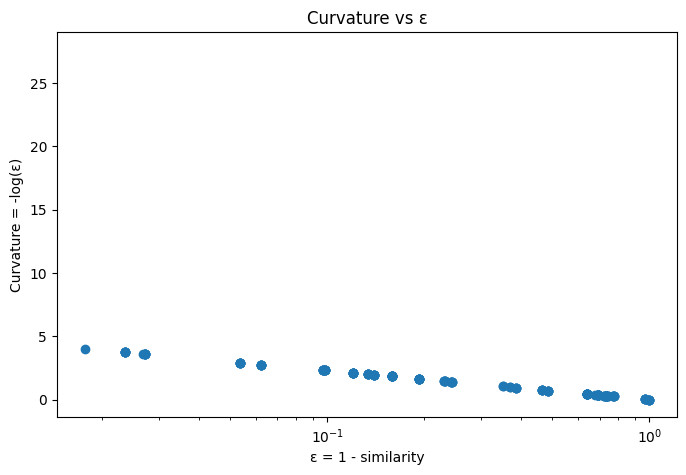

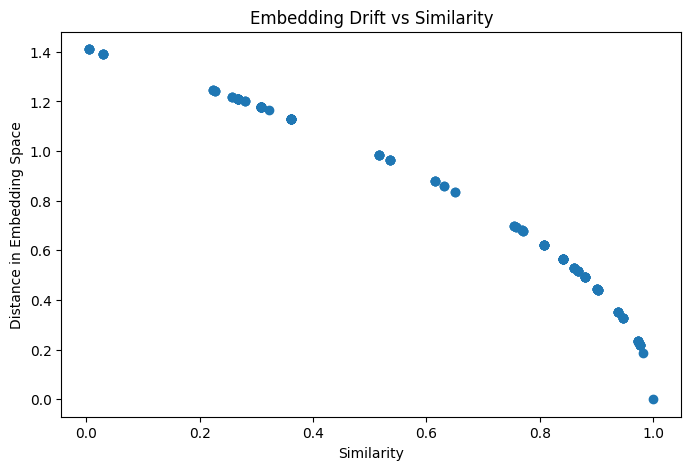

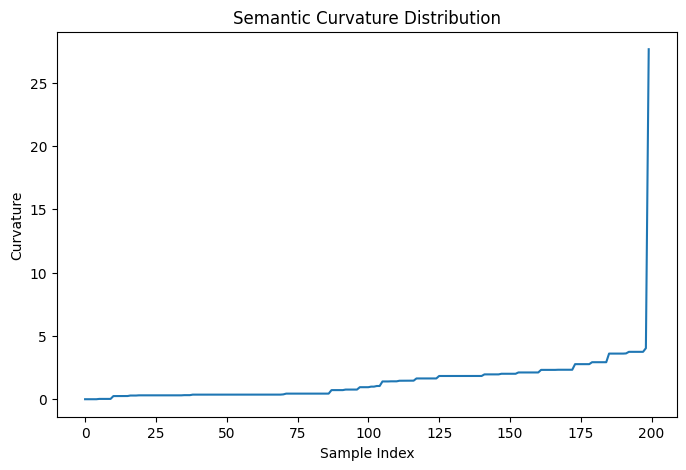


Experiment complete.
Your micro-counterfactual paradox graphs are ready.


In [6]:
# ============================================================
#  MICRO–COUNTERFACTUAL PARADOX: FULL EXPERIMENT NOTEBOOK
#  Stable, GPU-safe, Colab-ready, using flan-t5-base
# ============================================================

!pip install transformers sentence-transformers accelerate torch --quiet

import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA available:", torch.cuda.is_available())


# ------------------------------------------------------------
# 1. LOAD SEMANTIC MODEL (SBERT)
# ------------------------------------------------------------
semantic_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(DEVICE)


# ------------------------------------------------------------
# 2. LOAD PARAPHRASER (FLAN-T5-BASE)
# ------------------------------------------------------------
paraphraser_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(paraphraser_name)
model = AutoModelForSeq2SeqLM.from_pretrained(paraphraser_name).to(DEVICE)

print("Paraphraser loaded:", paraphraser_name)


# ------------------------------------------------------------
# 3. BASE PROMPTS
# ------------------------------------------------------------
BASE_PROMPTS = [
    "Explain the role of entropy in neural networks.",
    "Why do LLMs hallucinate?",
    "What is the purpose of regularization?",
    "Define gradient explosion in transformers.",
    "Explain attention heads like I'm five.",
    "How do embeddings represent meaning?",
    "What causes semantic drift in language models?",
    "Why do models fail at counterfactual reasoning?",
    "What is the KL divergence?",
    "Explain the meaning of cosine similarity.",
]

# Expand to 200 prompts for more variety
while len(BASE_PROMPTS) < 200:
    BASE_PROMPTS.append(random.choice(BASE_PROMPTS))


# ------------------------------------------------------------
# 4. PARAPHRASER FUNCTION
# ------------------------------------------------------------
def gen(text, n=4, max_len=128):
    """
    Generate paraphrases using flan-t5-base.
    """
    prompts = f"Paraphrase: {text}"
    inputs = tokenizer(prompts, return_tensors="pt").to(DEVICE)

    outputs = model.generate(
        **inputs,
        num_beams=4,
        num_return_sequences=n,
        max_length=max_len,
        temperature=0.7,
    )

    return [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]


# ------------------------------------------------------------
# 5. GENERATE PARAPHRASE PAIRS
# ------------------------------------------------------------
pairs = []
NUM_PAIRS = 200

print("\nGenerating paraphrase pairs...\n")

with tqdm(total=NUM_PAIRS) as pbar:
    while len(pairs) < NUM_PAIRS:
        src = random.choice(BASE_PROMPTS)
        paras = gen(src, n=4)

        src_emb = semantic_model.encode(src, convert_to_tensor=True)

        for p in paras:
            par_emb = semantic_model.encode(p, convert_to_tensor=True)
            sim = float(util.cos_sim(src_emb, par_emb)[0][0])

            pairs.append((src, p, sim))
            pbar.update(1)

            if len(pairs) >= NUM_PAIRS:
                break


df = pd.DataFrame(pairs, columns=["source", "paraphrase", "similarity"])
df.to_csv("paradox_pairs.csv", index=False)

print("Saved paradox_pairs.csv with", len(df), "pairs.")


# ------------------------------------------------------------
# 6. COMPUTE MICRO-COUNTERFACTUAL METRICS
# ------------------------------------------------------------

# ε = 1 - similarity
df["eps"] = 1 - df["similarity"]

# divergence = 1/ε  (theoretically blows up as eps→0)
df["divergence"] = 1 / df["eps"].replace(0, 1e-12)

# semantic distance (embedding drift)
def embedding_dist(s, p):
    e1 = semantic_model.encode(s, convert_to_tensor=True)
    e2 = semantic_model.encode(p, convert_to_tensor=True)
    return float(torch.norm(e1 - e2))

df["distance"] = df.apply(lambda r: embedding_dist(r["source"], r["paraphrase"]), axis=1)

# curvature = -log(ε)
df["curvature"] = -np.log(df["eps"].replace(0, 1e-12))


# ------------------------------------------------------------
# 7. PLOTS — THEORETICAL SIGNATURES
# ------------------------------------------------------------

plt.figure(figsize=(8,5))
plt.hist(df["similarity"], bins=20)
plt.title("Semantic Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(8,5))
plt.scatter(df["similarity"], df["divergence"])
plt.title("Divergence vs Similarity (Micro-Counterfactual Signature)")
plt.xlabel("Similarity")
plt.ylabel("Divergence = 1/ε")
plt.yscale("log")
plt.show()


plt.figure(figsize=(8,5))
plt.scatter(df["eps"], df["curvature"])
plt.title("Curvature vs ε")
plt.xlabel("ε = 1 - similarity")
plt.ylabel("Curvature = -log(ε)")
plt.xscale("log")
plt.show()


plt.figure(figsize=(8,5))
plt.scatter(df["similarity"], df["distance"])
plt.title("Embedding Drift vs Similarity")
plt.xlabel("Similarity")
plt.ylabel("Distance in Embedding Space")
plt.show()


plt.figure(figsize=(8,5))
plt.plot(sorted(df["curvature"]))
plt.title("Semantic Curvature Distribution")
plt.xlabel("Sample Index")
plt.ylabel("Curvature")
plt.show()


print("\nExperiment complete.")
print("Your micro-counterfactual paradox graphs are ready.")
